<a href="https://colab.research.google.com/github/rmoolchandani/rmoolcha_Capstone/blob/main/Code/Part_3_Modeling_%26_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

__Imports__

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import sklearn.metrics as metrics
from sklearn.utils import resample

__Read the modeling file and create a pandas dataframe__

In [ ]:
# Connect to Google Drive
# Upload the dataset to your Google drive so it can be loaded here
from google.colab import drive
drive.mount('/content/gdrive')

# load the csv file
model = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/diabetic_data_modeling.csv')
model.head()

Mounted at /content/gdrive


,Unnamed: 0,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,glyburide-metformin,change,diabetesMed,readmitted,age_range
0,0,0,0,[10-20),0,0,0,3,59,0,18,0,0,0,7,7,7,9,0,0,0,0,0,0,0,0,0,0,2,0,0,1,1,1
1,1,1,0,[20-30),0,0,0,2,11,5,13,2,0,1,6,3,8,6,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,2
2,2,0,1,[30-40),0,0,0,2,44,1,16,0,0,0,8,7,0,7,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,4
3,3,0,1,[40-50),0,0,0,1,51,0,8,0,0,0,7,7,3,5,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,5
4,4,0,1,[50-60),2,0,2,3,31,6,16,0,0,0,0,0,3,9,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,6


In [ ]:
model.info

<bound method DataFrame.info of        Unnamed: 0  race  gender  ... diabetesMed  readmitted  age_range
0               0     0       0  ...           1           1          1
1               1     1       0  ...           1           0          2
2               2     0       1  ...           1           0          4
3               3     0       1  ...           1           0          5
4               4     0       1  ...           1           1          6
...           ...   ...     ...  ...         ...         ...        ...
94615       98047     1       1  ...           1           1          9
94616       98048     1       0  ...           1           0          7
94617       98049     0       1  ...           1           0          9
94618       98050     0       0  ...           1           0          7
94619       98051     0       1  ...           0           0          9

[94620 rows x 34 columns]>

In [ ]:
model.drop('Unnamed: 0', axis =1, inplace = True)

In [ ]:
model.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin',
       'glyburide-metformin', 'change', 'diabetesMed', 'readmitted',
       'age_range'],
      dtype='object')

In [ ]:
model.dtypes

race                         int64
gender                       int64
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                       int64
diag_2                       int64
diag_3                       int64
number_diagnoses             int64
max_glu_serum                int64
A1Cresult                    int64
metformin                    int64
repaglinide                  int64
nateglinide                  int64
glimepiride                  int64
glipizide                    int64
glyburide                    int64
pioglitazone                 int64
rosiglitazone                int64
insulin                      int64
glyburide-metformin 

__Baseline__

In [ ]:
model.readmitted.value_counts(normalize = True)

0    0.532002
1    0.467998
Name: readmitted, dtype: float64

In [ ]:
# create X (features) and y (target)
X = model.drop(['readmitted', 'age'], axis=1)
y = model['readmitted']

__Train/Test Split__

In [ ]:
# split X and y into cross-validation (80%) and testing (20%) data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.20, random_state=123, stratify = y)

__Scaling of data__

In [ ]:
# Instantiate.
ss = StandardScaler()

# Fit and transform.
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

__Resampling techniques — Undersample majority class__

Since we have an unbalanced dataset, We will use sampling technique.

In [ ]:
X = pd.concat([X_train, y_train], axis=1)

not_readmitted = X[X.readmitted==0]
readmitted = X[X.readmitted==1]

not_readmitted_sampled = resample(not_readmitted,
                                replace = False, 
                                n_samples = len(readmitted),
                                random_state = 42)

downsampled = pd.concat([not_readmitted_sampled, readmitted])

downsampled.readmitted.value_counts()

1    35426
0    35426
Name: readmitted, dtype: int64

In [ ]:
y_train = downsampled.readmitted
X_train = downsampled.drop('readmitted', axis=1)

__Train-Validation Splitting__

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)

__Modelling__

__Model Selection__

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score,f1_score
from sklearn.metrics import confusion_matrix as cm

In [ ]:
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    fscore = f1_score(y_actual,(y_pred > thresh) )
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('fscore:%.3f'%fscore)
    print('specificity:%.3f'%specificity)
    print(' ')
    return auc, accuracy, recall, precision,fscore, specificity

In [ ]:
thresh = 0.5

__Model Selection: Baseline Models__

__Naive Bayes Classifier__

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB().fit(X_train, y_train)

In [ ]:
y_train_preds = nb_model.predict_proba(X_train)[:,1]
y_val_preds = nb_model.predict_proba(X_val)[:,1]

print("Naive Bayes Classifier")
print('Training:')
nb_train_auc, nb_train_accuracy, nb_train_recall, \
    nb_train_precision, nb_train_fscore, nb_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
nb_val_auc, nb_val_accuracy, nb_val_recall, \
    nb_val_precision,nb_val_fscore, nb_val_specificity = print_report(y_val,y_val_preds, thresh)

Naive Bayes Classifier
Training:
AUC:0.637
accuracy:0.573
recall:0.294
precision:0.665
fscore:0.408
specificity:0.853
 
Validation:
AUC:0.637
accuracy:0.574
recall:0.294
precision:0.672
fscore:0.409
specificity:0.856
 


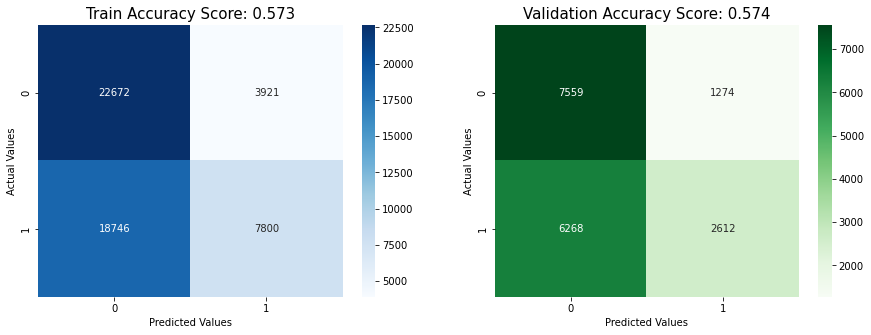

In [ ]:
# Confusion Matrix

predictions = nb_model.predict(X_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = cm(y_train, predictions)

predictions = nb_model.predict(X_val)
val_score = round(accuracy_score(y_val, predictions), 3)
cm_val = cm(y_val, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1, cmap='Blues')
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Train Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2, cmap='Greens')
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

__K Nearest Neighbours__

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors = 100).fit(X_train, y_train)

In [ ]:
y_train_preds = knn_model.predict_proba(X_train)[:,1]
y_val_preds = knn_model.predict_proba(X_val)[:,1]

print("k Nearest Neighbours")
print('Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision, knn_train_fscore, knn_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
knn_val_auc, knn_val_accuracy, knn_val_recall, \
    knn_val_precision,knn_val_fscore, knn_val_specificity = print_report(y_val,y_val_preds, thresh)

k Nearest Neighbours
Training:
AUC:0.637
accuracy:0.598
recall:0.523
precision:0.615
fscore:0.565
specificity:0.625
 
Validation:
AUC:0.606
accuracy:0.573
recall:0.492
precision:0.588
fscore:0.536
specificity:0.604
 


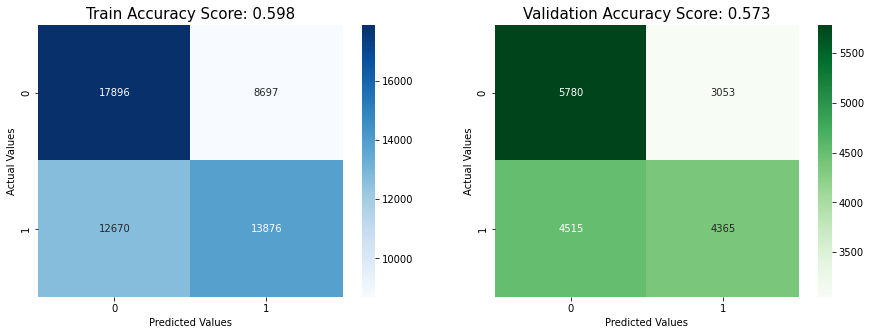

In [ ]:
# Confusion Matrix

predictions = knn_model.predict(X_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = cm(y_train, predictions)

predictions = knn_model.predict(X_val)
val_score = round(accuracy_score(y_val, predictions), 3)
cm_val = cm(y_val, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1, cmap='Blues')
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Train Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2, cmap='Greens')
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

__Logistic Regression__

In [ ]:
log_model = LogisticRegression(solver = "liblinear",class_weight="balanced",random_state = 42).fit(X_train, y_train)

In [ ]:
y_train_preds = log_model.predict_proba(X_train)[:,1]
y_val_preds = log_model.predict_proba(X_val)[:,1]

print("Logistic Regression")
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_fscore, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
lr_val_auc, lr_val_accuracy, lr_val_recall, \
    lr_val_precision,lr_val_fscore, lr_val_specificity = print_report(y_val,y_val_preds, thresh)

Logistic Regression
Training:
AUC:0.658
accuracy:0.613
recall:0.529
precision:0.635
fscore:0.577
specificity:0.697
 
Validation:
AUC:0.658
accuracy:0.608
recall:0.523
precision:0.631
fscore:0.572
specificity:0.692
 


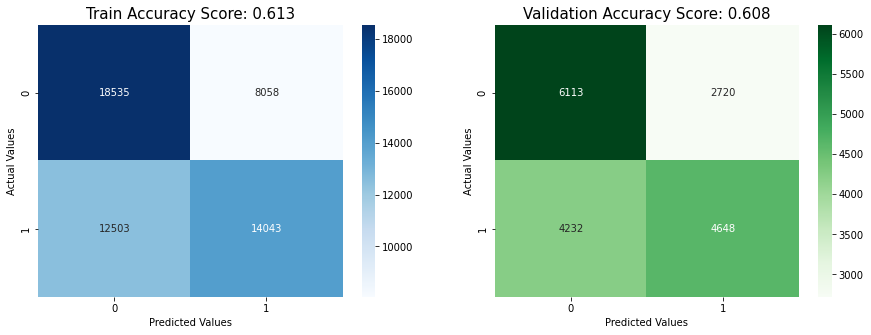

In [ ]:
# Confusion Matrix

predictions = log_model.predict(X_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = cm(y_train, predictions)

predictions = log_model.predict(X_val)
val_score = round(accuracy_score(y_val, predictions), 3)
cm_val = cm(y_val, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1, cmap='Blues')
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Train Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2, cmap='Greens')
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

__Decision Tree__

In [ ]:
dt_model = DecisionTreeClassifier(max_depth = 10, random_state = 42).fit(X_train, y_train)

In [ ]:
y_train_preds = dt_model.predict_proba(X_train)[:,1]
y_val_preds = dt_model.predict_proba(X_val)[:,1]

print("Decision Tree")
print('Training:')
dt_train_auc, dt_train_accuracy, dt_train_recall, \
    dt_train_precision, dt_train_fscore, dt_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
dt_val_auc, dt_val_accuracy, dt_val_recall, \
    dt_val_precision,dt_val_fscore, dt_val_specificity = print_report(y_val,y_val_preds, thresh)

Decision Tree
Training:
AUC:0.711
accuracy:0.647
recall:0.642
precision:0.648
fscore:0.645
specificity:0.649
 
Validation:
AUC:0.632
accuracy:0.599
recall:0.588
precision:0.602
fscore:0.595
specificity:0.606
 


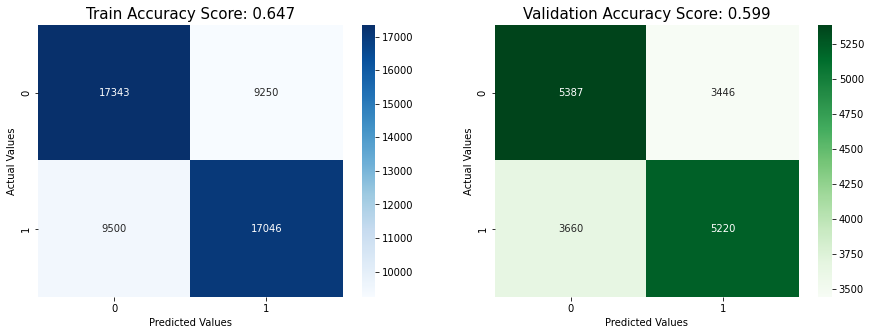

In [ ]:
# Confusion Matrix

predictions = dt_model.predict(X_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = cm(y_train, predictions)

predictions = dt_model.predict(X_val)
val_score = round(accuracy_score(y_val, predictions), 3)
cm_val = cm(y_val, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1, cmap='Blues')
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Train Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2, cmap='Greens')
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

__Random Forest Classifier__

In [ ]:
random_forest_model = RandomForestClassifier(random_state=42, max_depth=6)
random_forest_model.fit(X_train, y_train) 

RandomForestClassifier(max_depth=6, random_state=42)

In [ ]:
y_train_preds = random_forest_model.predict_proba(X_train)[:,1]
y_val_preds = random_forest_model.predict_proba(X_val)[:,1]

print("Random Forest")
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision,rf_train_fscore, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_val_auc, rf_val_accuracy, rf_val_recall, rf_val_precision,rf_val_fscore, rf_val_specificity = print_report(y_val,y_val_preds, thresh)

Random Forest
Training:
AUC:0.672
accuracy:0.620
recall:0.547
precision:0.640
fscore:0.590
specificity:0.694
 
Validation:
AUC:0.663
accuracy:0.616
recall:0.541
precision:0.638
fscore:0.585
specificity:0.691
 


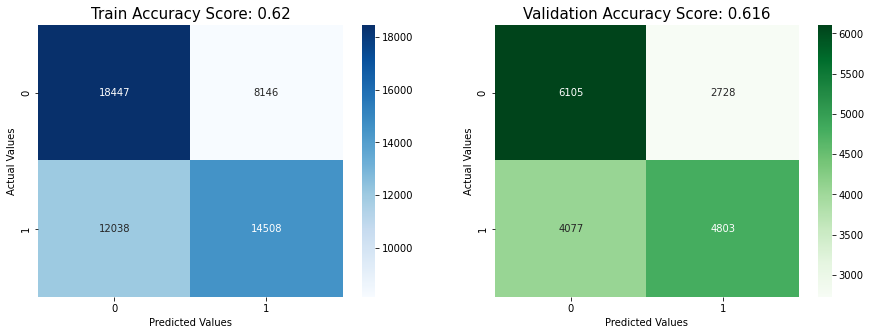

In [ ]:
# Confusion Matrix

predictions = random_forest_model.predict(X_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = cm(y_train, predictions)

predictions = random_forest_model.predict(X_val)
val_score = round(accuracy_score(y_val, predictions), 3)
cm_val = cm(y_val, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1, cmap='Blues')
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Train Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2, cmap='Greens')
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

__XGBOOST Classifier__

In [ ]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(random_state=42, n_jobs=-1,max_depth=3)
xgb_model.fit(X_train, y_train)

XGBClassifier(n_jobs=-1, random_state=42)

In [ ]:
y_train_preds = xgb_model.predict_proba(X_train)[:,1]
y_val_preds = xgb_model.predict_proba(X_val)[:,1]

print("XGBOOST")
y_train_preds = xgb_model.predict_proba(X_train)[:,1]
y_val_preds = xgb_model.predict_proba(X_val)[:,1]

print('Training:')
xgb_train_auc, xgb_train_accuracy, xgb_train_recall, xgb_train_precision, xgb_train_fscore, xgb_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
xgb_val_auc, xgb_val_accuracy, xgb_val_recall, xgb_val_precision,xgb_val_fscore, xgb_val_specificity = print_report(y_val,y_val_preds, thresh)

XGBOOST
Training:
AUC:0.681
accuracy:0.627
recall:0.572
precision:0.643
fscore:0.605
specificity:0.682
 
Validation:
AUC:0.671
accuracy:0.622
recall:0.563
precision:0.639
fscore:0.599
specificity:0.681
 


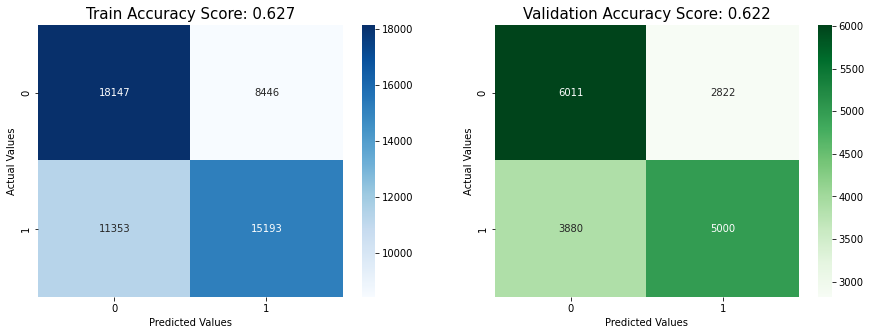

In [ ]:
# Confusion Matrix

predictions = xgb_model.predict(X_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = cm(y_train, predictions)

predictions = xgb_model.predict(X_val)
val_score = round(accuracy_score(y_val, predictions), 3)
cm_val = cm(y_val, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1, cmap='Blues')
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Train Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2, cmap='Greens')
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

__Analyze results baseline models__

In [ ]:
base_models_results = pd.DataFrame({'classifier':['NB','NB','KNN','KNN','LOR','LOR','DT','DT','RF','RF','XGB','XGB'],
                           'data_set':['train','val']*6,
                          'auc':[nb_train_auc, nb_val_auc, knn_train_auc, knn_val_auc, lr_train_auc, lr_val_auc, dt_train_auc, dt_val_auc, rf_train_auc, rf_val_auc, xgb_train_auc, xgb_val_auc],
                          'accuracy':[nb_train_accuracy, nb_val_accuracy, knn_train_accuracy, knn_val_accuracy, lr_train_accuracy, lr_val_accuracy, dt_train_accuracy, dt_val_accuracy, rf_train_accuracy, rf_val_accuracy, xgb_train_accuracy,xgb_val_accuracy],
                          'recall':[nb_train_recall, nb_val_recall, knn_train_recall, knn_val_recall, lr_train_recall, lr_val_recall, dt_train_recall, dt_val_recall, rf_train_recall, rf_val_recall, xgb_train_recall,xgb_val_recall],
                          'precision':[nb_train_precision, nb_val_precision, knn_train_precision, knn_val_precision, lr_train_precision, lr_val_precision, dt_train_precision, dt_val_precision, rf_train_precision, rf_val_precision, xgb_train_precision, xgb_val_precision],
                          'fscore':[nb_train_fscore, nb_val_fscore, knn_train_fscore, knn_val_fscore, lr_train_fscore, lr_val_fscore, dt_train_fscore, dt_val_fscore, rf_train_fscore, rf_val_fscore, xgb_train_fscore, xgb_val_fscore],
                          'specificity':[nb_train_specificity, nb_val_specificity, knn_train_specificity, knn_val_specificity, lr_train_specificity, lr_val_specificity, dt_train_specificity, dt_val_specificity, rf_train_specificity,rf_val_specificity, xgb_train_specificity, xgb_val_specificity]})

In [ ]:
base_models_results

,classifier,data_set,auc,accuracy,recall,precision,fscore,specificity
0,NB,train,0.637392,0.573439,0.293830,0.665472,0.407662,0.852555
1,NB,val,0.636596,0.574211,0.294144,0.672156,0.409212,0.855768
2,KNN,train,0.636595,0.597904,0.522715,0.614717,0.564995,0.625089
3,KNN,val,0.606483,0.572743,0.491554,0.588434,0.535649,0.604098
4,LOR,train,0.658480,0.613071,0.529006,0.635401,0.577343,0.696988
5,LOR,val,0.658296,0.607520,0.523423,0.630836,0.572132,0.692064
6,DT,train,0.711016,0.647152,0.642131,0.648235,0.645169,0.648629
7,DT,val,0.632333,0.598826,0.587838,0.602354,0.595007,0.605796
8,RF,train,0.671753,0.620166,0.546523,0.640417,0.589756,0.693679
9,RF,val,0.663065,0.615819,0.540878,0.637764,0.585339,0.691158


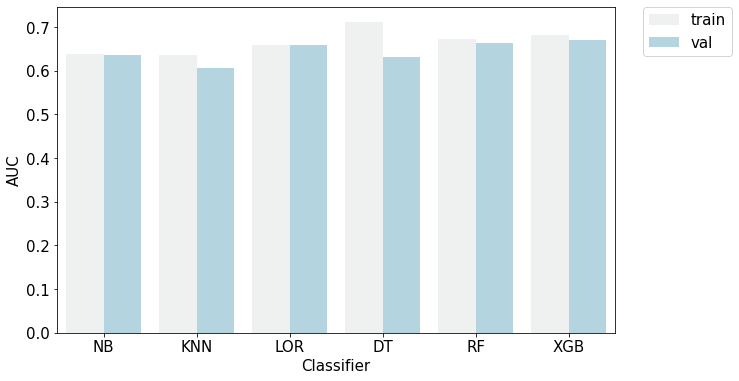

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=base_models_results, color='lightblue')
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

__Model Selection: Learning Curve__

In [ ]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

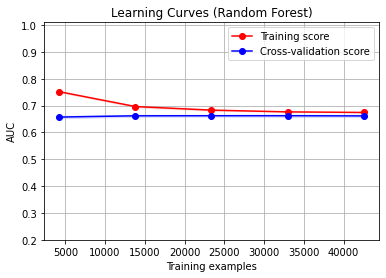

In [ ]:
title = "Learning Curves (Random Forest)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = RandomForestClassifier(max_depth = 6, random_state = 42)
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

In the case of random forest, we can see the training and validation scores are similar but they both have low scores. This is called high bias and is a sign of underfitting. 

Depending on your learning curve, there are a few strategies you can employ to improve your models

High Bias:
- Add new features
- Increase model complexity
- Reduce regularization
- Change model architecture 


High Variance:
- Add more samples
- Add regularization
- Reduce number of features
- Decrease model complexity
- Add better features
- Change model architecture


Source: Andrew Ng's [Coursera class](https://www.coursera.org/specializations/deep-learning?utm_source=gg&utm_medium=sem&campaignid=904733485&adgroupid=54215108588&device=c&keyword=andrew%20ng&matchtype=p&network=g&devicemodel=&adpostion=1t1&creativeid=231631799402&hide_mobile_promo&gclid=Cj0KCQjwk_TbBRDsARIsAALJSOZlkCoqhf68wjopusy6Kzw1qewNAEC-9H0K1LhwOwRZ2llTZtVINicaAiG-EALw_wcB) paraphrased on <https://www.learnopencv.com/bias-variance-tradeoff-in-machine-learning/> and Andrew Ng's Machine Learning Yearning textbook. 


__Feature Importance__

__Feature Importance with XGBoost Classifier__

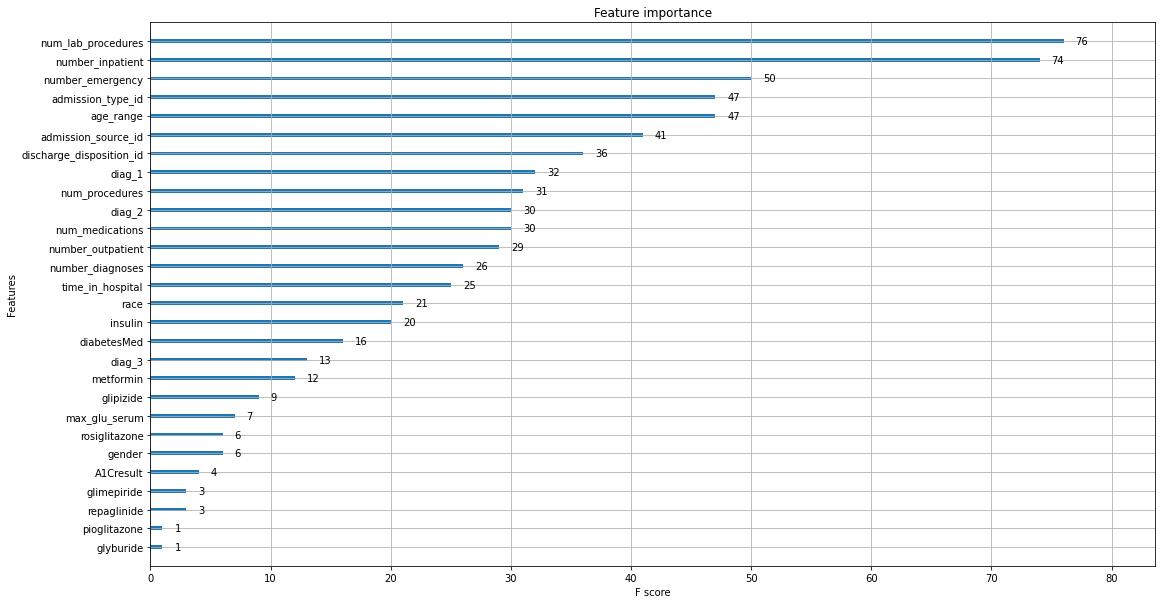

In [ ]:
import xgboost as xgb

plt.rcParams["figure.figsize"] = (18, 10)
xgb.plot_importance(xgb_model)

feature_imp = pd.Series(xgb_model.feature_importances_, index = X_train.columns)
best_features = feature_imp.nlargest(25)

In [ ]:
best_features.index

Index(['number_inpatient', 'number_diagnoses', 'diabetesMed',
       'number_outpatient', 'number_emergency', 'admission_source_id',
       'max_glu_serum', 'time_in_hospital', 'age_range', 'num_medications',
       'admission_type_id', 'discharge_disposition_id', 'metformin',
       'num_procedures', 'num_lab_procedures', 'insulin', 'diag_1', 'diag_2',
       'glipizide', 'gender', 'race', 'repaglinide', 'A1Cresult', 'diag_3',
       'glyburide'],
      dtype='object')

In [ ]:
X_train_importance = X_train[best_features.index]
X_val_importance = X_val[best_features.index]
X_test_importance = X_test[best_features.index]

__Hyperparameter Tuning__

__Random Forest Classifier Model Tuning__

In [ ]:
random_forest_model.get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# number of trees
n_estimators = range(200,1000,200)
# maximum number of features to use at each split
max_features = ['auto','sqrt']
# maximum depth of the tree
max_depth = range(1,10,1)
# minimum number of samples to split a node
min_samples_split = range(2,10,2)
# criterion for evaluating a split
criterion = ['gini','entropy']

# random grid

random_grid = {'n_estimators':n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'criterion':criterion}

print(random_grid)

{'n_estimators': range(200, 1000, 200), 'max_features': ['auto', 'sqrt'], 'max_depth': range(1, 10), 'min_samples_split': range(2, 10, 2), 'criterion': ['gini', 'entropy']}


In [ ]:
from sklearn.metrics import make_scorer, roc_auc_score
auc_scoring = make_scorer(roc_auc_score)

In [ ]:
# create the randomized search cross-validation
rf_random = RandomizedSearchCV(estimator = random_forest_model, param_distributions = random_grid, 
                               n_iter = 20, cv = 2, scoring=auc_scoring,
                               verbose = 1, random_state = 42)

In [ ]:
# fit the random search model (this will take a few minutes)
import time
t1 = time.time()
rf_random.fit(X_train_importance, y_train)
t2 = time.time()
print(t2-t1)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
368.1386456489563


In [ ]:
rf_random.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 800}

In [ ]:
y_train_preds = random_forest_model.predict_proba(X_train)[:,1]
y_val_preds = random_forest_model.predict_proba(X_val)[:,1]

print('Baseline Random Forest')
rf_train_auc_base = roc_auc_score(y_train, y_train_preds)
rf_val_auc_base = roc_auc_score(y_val, y_val_preds)

print('Training AUC:%.3f'%(rf_train_auc_base))
print('Validation AUC:%.3f'%(rf_val_auc_base))

print('Optimized Random Forest')
y_train_preds_random = rf_random.best_estimator_.predict_proba(X_train_importance)[:,1]
y_val_preds_random = rf_random.best_estimator_.predict_proba(X_val_importance)[:,1]

rf_train_auc = roc_auc_score(y_train, y_train_preds_random)
rf_val_auc = roc_auc_score(y_val, y_val_preds_random)

print('Training AUC:%.3f'%(rf_train_auc))
print('Validation AUC:%.3f'%(rf_val_auc))

Baseline Random Forest
Training AUC:0.672
Validation AUC:0.663
Optimized Random Forest
Training AUC:0.714
Validation AUC:0.669


__XGBoost Classifier Model Tuning__

In [ ]:
# number of trees
n_estimators = range(100,500,100)

# maximum depth of the tree
max_depth = range(1,5,1)

# learning rate
learning_rate = [0.001,0.01,0.1]

# random grid

random_grid_xgbc = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'learning_rate':learning_rate}

# create the randomized search cross-validation
xgbc_random = RandomizedSearchCV(estimator = xgb_model, param_distributions = random_grid_xgbc,
                                n_iter = 20, cv = 2, scoring=auc_scoring,
                                verbose = 0, random_state = 42)

t1 = time.time()
xgbc_random.fit(X_train_importance, y_train)
t2 = time.time()
print(t2-t1)


160.55984234809875


In [ ]:
xgbc_random.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}

In [ ]:
y_train_preds = xgb_model.predict_proba(X_train)[:,1]
y_val_preds = xgb_model.predict_proba(X_val)[:,1]

print('Baseline XGB')
xgb_train_auc_base = roc_auc_score(y_train, y_train_preds)
xgb_val_auc_base = roc_auc_score(y_val, y_val_preds)

print('Training AUC:%.3f'%(xgb_train_auc_base))
print('Validation AUC:%.3f'%(xgb_val_auc_base))

print('Optimized XGB')
y_train_preds_xgb = xgbc_random.best_estimator_.predict_proba(X_train_importance)[:,1]
y_val_preds_xgb = xgbc_random.best_estimator_.predict_proba(X_val_importance)[:,1]

xgb_train_auc = roc_auc_score(y_train, y_train_preds_xgb)
xgb_val_auc = roc_auc_score(y_val, y_val_preds_xgb)

print('Training AUC:%.3f'%(xgb_train_auc))
print('Validation AUC:%.3f'%(xgb_val_auc))

Baseline XGB
Training AUC:0.681
Validation AUC:0.671
Optimized XGB
Training AUC:0.707
Validation AUC:0.673


__Hyperparameter Tuning Results__

In [ ]:
data_results = pd.DataFrame({'classifier':['RF','RF','XGB','XGB'],
                           'data_set':['base','optimized']*2,
                          'auc':[rf_val_auc_base,rf_val_auc,
                                 xgb_val_auc_base,xgb_val_auc,
                                ],
                          })

In [ ]:
data_results

,classifier,data_set,auc
0,RF,base,0.663065
1,RF,optimized,0.669049
2,XGB,base,0.670900
3,XGB,optimized,0.672530


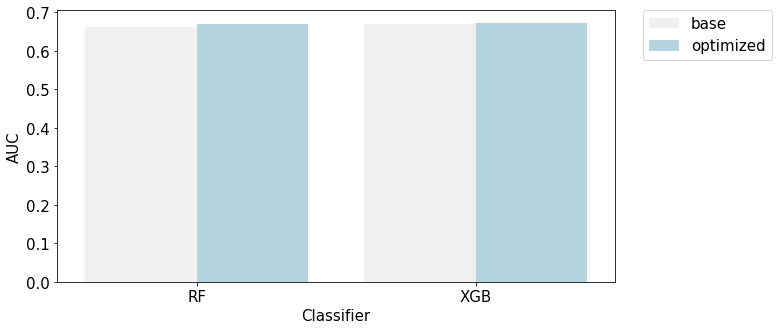

In [ ]:
fig = plt.figure(figsize=(10,5),)
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=data_results, color = 'lightblue')
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

__Roc-Auc Comparison of Models__

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,recall_score,mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report

classifiers = [ rf_random.best_estimator_,
                xgbc_random.best_estimator_]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    yproba = cls.predict_proba(X_test_importance)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)
result_table.sort_values('auc',ascending=False,inplace=True)

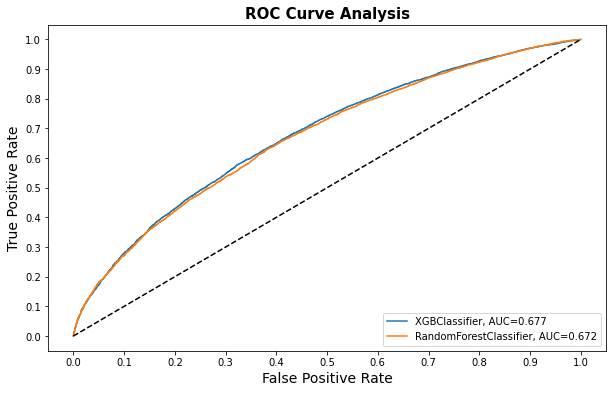

In [ ]:
fig = plt.figure(figsize=(10,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='black', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=14)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=14)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':10}, loc='lower right')

plt.show()

In [ ]:
def test_scores(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    
    return auc, accuracy, recall


classifiers = [ rf_random.best_estimator_,
                xgbc_random.best_estimator_]

# Define a result table as a DataFrame
test_result = pd.DataFrame(columns=['classifiers', 'accuracy','recall','auc'])

# Train the models and record the results
for cls in classifiers:
    y_test_preds = cls.predict_proba(X_test_importance)[:,1]
    
    test_auc, test_accuracy, test_recall = test_scores(y_test,y_test_preds, 0.5) # thresh = 0.5
    
    test_result = test_result.append({'classifiers':cls.__class__.__name__,
                                        'accuracy':test_accuracy, 
                                        'recall':test_recall, 
                                        'auc':test_auc}, ignore_index=True)


# Set name of the classifiers as index labels
test_result.set_index('classifiers', inplace=True)
test_result.sort_values('auc',ascending=False,inplace=True)

In [ ]:
test_result

,accuracy,recall,auc
classifiers,,,
XGBClassifier,0.628831,0.589770,0.677323
RandomForestClassifier,0.621327,0.545054,0.671795


In [ ]:
import plotly.graph_objs as go

trace1=go.Bar(
                x=test_result.index,
                y=test_result.accuracy,
                name="Accuracy",
                marker= dict(color = 'LightBlue',
                            line=dict(color='rgb(0,0,0)',width=1.0)),
                text=round(test_result.accuracy,3),textposition='auto')
trace2=go.Bar(
                x=test_result.index,
                y=test_result.recall,
                name="Recall",
                marker=dict(color = 'lightYellow',
                           line=dict(color='rgb(0,0,0)',width=1.0)),
                text=round(test_result.recall,3),textposition='auto')
trace3=go.Bar(
                x=test_result.index,
                y=test_result.auc,
                name="AUC",
                marker=dict(color = 'LightGreen',
                           line=dict(color='rgb(0,0,0)',width=1.0)),
                text=round(test_result.auc,3),textposition='auto')

edit_df=[trace1,trace2,trace3]
layout = { 'barmode':'group',
           'title_text':'Accuracy, Recall and AUC Plot Readmitted' }

fig= go.Figure(data=edit_df,layout=go.Layout(
    autosize=False,
    width=800,
    height=600,))
#plt.savefig('graph.png')
fig.show()

__Prediction Result__

__Model Selection: Best Classifier__

In [ ]:
best_model = xgbc_random

y_train_preds = best_model.predict_proba(X_train_importance)[:,1]
y_valid_preds = best_model.predict_proba(X_val_importance)[:,1]
y_test_preds = best_model.predict_proba(X_test_importance)[:,1]

In [ ]:
thresh = 0.5

print('Training:')
train_auc, train_accuracy, train_recall, train_precision, train_fscore, train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
val_auc, val_accuracy, val_recall, val_precision, val_fscore,val_specificity = print_report(y_val,y_val_preds, thresh)
print('Test:')
test_auc, test_accuracy, test_recall, test_precision, test_fscore, test_specificity = print_report(y_test,y_test_preds, thresh)

Training:
AUC:0.707
accuracy:0.647
recall:0.612
precision:0.658
fscore:0.634
specificity:0.682
 
Validation:
AUC:0.671
accuracy:0.622
recall:0.563
precision:0.639
fscore:0.599
specificity:0.681
 
Test:
AUC:0.677
accuracy:0.629
recall:0.590
precision:0.606
fscore:0.598
specificity:0.663
 


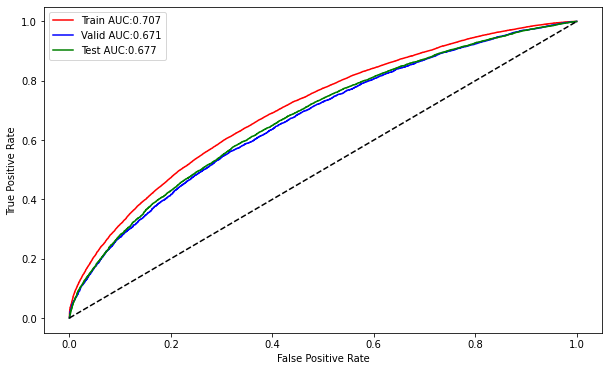

In [ ]:
from sklearn.metrics import roc_curve 

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_val_preds)
auc_val = roc_auc_score(y_val, y_val_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

fig, ax = plt.subplots(figsize=(10,6)) 
plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_val, tpr_val, 'b-',label ='Valid AUC:%.3f'%auc_val)
plt.plot(fpr_test, tpr_test, 'g-',label ='Test AUC:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

__Conclusion__

Based on the Auc results observed in the best classifier train, validation and test set results. It was observed that the best model was Catboost. The test result was almost 67.7% succesful. it was concluded that 67.7% of the patients returned to the hospital within 30 days and predicted correctly.